In [12]:
%load_ext autoreload
%autoreload 2
# when debugging the python scripts, with the autoreload the jupyter notebook sync's to the most up to date scripts. See: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
from dataprep import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import sklearn.model_selection as skm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
#from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import random
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
seed = 101
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
rng = np.random.RandomState(seed)

In [3]:
adata = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/custom_nynke_panel_simulated_embeddings_adata.h5ad")

In [5]:
len(adata_pericellular[adata_pericellular.obs['n_spots']<11].obs['cell_id'].unique())

315

In [11]:
# For now define high count as 140+ spots, and low count as 11- spots.
def subsetGenes(adata, pattern: str = 'pericellular', pattern_strength: int = 0.9, count_threshold: int = 11, high_or_low: str = 'low'):
    
    adata_filtered = adata[(adata.obs['pattern'] == pattern) & 
                           (adata.obs['n_spots'] < count_threshold if high_or_low == 'low' else adata.obs['n_spots'] > count_threshold) & 
                           (adata.obs['prop'] == pattern_strength)].copy()

    
    subset_dict = {}
    i = 0
    while len(adata_filtered.obs['cell_id'].unique()) > 0:
        # Group by 'cell_id'
        grouped = adata_filtered.obs.groupby('cell_id')

        # For each group, select at most one item
        subsets = [group.sample(n=1) for _, group in grouped]

        # Concatenate the results back into a DataFrame
        subset_obs = pd.concat(subsets)

        # Use this DataFrame to subset the original anndata object and store in dictionary, while omitting the selected cells from the original adata object
        count_subset = adata_filtered[adata_filtered.obs.index.isin(subset_obs.index)].copy()
        subset_dict[i] = count_subset
        adata_filtered = adata_filtered[~adata_filtered.obs.index.isin(subset_obs.index)].copy()
        i += 1

    return subset_dict


In [10]:
test_dict = subsetGenes(adata, 'pericellular', 0.9, 11, 'low')
test_dict

{0: AnnData object with n_obs × n_vars = 258 × 15
     obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'prop', 'prop_interval', 'corresponding_dapis', 'train_or_val', 'original_image_paths'
     obsm: 'latent',
 1: AnnData object with n_obs × n_vars = 258 × 15
     obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'prop', 'prop_interval', 'corresponding_dapis', 'train_or_val', 'original_image_paths'
     obsm: 'latent',
 2: AnnData object with n_obs × n_vars = 258 × 15
     obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'prop', 'prop_interval', 'corresponding_dapis', 'train_or_val', 'original_image_paths'
     obsm: 'latent',
 3: AnnData object with n_obs × n_vars = 258 × 15
     obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', '

# Plan of attack

1. predict all the items within a single dictionary.
2. Do the same for the random genes.
3. group results together in a dataframe. Columns: RF_results, group, pattern (so can subset for the patterns when doing regression)
4. do logistic regression on the dataframe to see if there is a significant difference

## Check f1 score for protrusion data with pattern strength 0.45 iso 0.9

In [59]:
adata_all = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/all_spots_simulated_embeddings_adata.h5ad")

In [72]:
adata_all[adata_all.obs['pattern']=='protrusion']

View of AnnData object with n_obs × n_vars = 0 × 15
    obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'prop', 'prop_interval', 'corresponding_dapis', 'train_or_val', 'original_image_paths'
    uns: 'neighbors', 'pattern_colors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'latent'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [73]:
import scanpy as sc, anndata as ad, numpy as np, pandas as pd

In [74]:
adata_concat = ad.concat([adata_all,adata_protrude], merge="same")
adata_concat[adata_concat.obs['pattern']=='protrusion']

View of AnnData object with n_obs × n_vars = 37979 × 15
    obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'prop', 'prop_interval', 'corresponding_dapis', 'train_or_val', 'original_image_paths'
    obsm: 'latent'

In [70]:
protrude_adata = adata[adata.obs['pattern']=='protrusion']
adata_protrude = protrude_adata[protrude_adata.obs['prop']==0.4]
adata_protrude

View of AnnData object with n_obs × n_vars = 37979 × 15
    obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'prop', 'prop_interval', 'corresponding_dapis', 'train_or_val', 'original_image_paths'
    obsm: 'latent'

In [78]:
# Step 1: Group indices by cell_id
all_indices = adata_concat.obs.index
cell_ids = np.array(adata_concat.obs['cell_id'])
unique_cell_ids, cell_id_indices = np.unique(cell_ids, return_inverse=True)

# Step 3: Perform train-val-test split on cell_ids, maintaining the grouping
train_indices, test_val_indices = skm.train_test_split(np.arange(len(unique_cell_ids)), test_size=0.2, random_state=seed)
val_indices, test_indices = skm.train_test_split(test_val_indices, test_size=0.5, random_state=seed)

# Step 4: Map the grouped indices back to the original indices
train_indices = np.concatenate([np.where(cell_id_indices == i)[0] for i in train_indices])
val_indices = np.concatenate([np.where(cell_id_indices == i)[0] for i in val_indices])
test_indices = np.concatenate([np.where(cell_id_indices == i)[0] for i in test_indices])

# Step 5: Subset AnnData object using the obtained indices
adata_train = adata_concat[train_indices, :] # Training set:   176162 x 15
adata_val = adata_concat[val_indices, :]     # Validation set: 22269 x 15
adata_test = adata_concat[test_indices, :]   # Test set:       22256 x 15

In [79]:
adata_train_pattern = adata_train.copy()
adata_train_pattern = adata_train_pattern[adata_train_pattern.obs['pattern']!='random']
adata_val_pattern = adata_val.copy()
adata_val_pattern = adata_val_pattern[adata_val_pattern.obs['pattern']!='random']

<ipython-input-80-5f17c46949c9>:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_train_pattern.obs["protrusion"] = np.where(adata_train_pattern.obs["pattern"] == "protrusion", "protrusion", "other")
<ipython-input-80-5f17c46949c9>:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_val_pattern.obs["protrusion"] = np.where(adata_val_pattern.obs["pattern"] == "protrusion", "protrusion", "other")


f1 score: 
0.8601307189542483


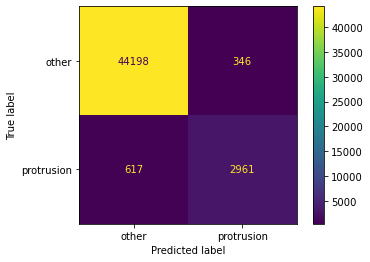

In [80]:
adata_train_pattern.obs["protrusion"] = np.where(adata_train_pattern.obs["pattern"] == "protrusion", "protrusion", "other")
adata_val_pattern.obs["protrusion"] = np.where(adata_val_pattern.obs["pattern"] == "protrusion", "protrusion", "other")
 # create random forest classifier EXCLUDING random
rf_classifier = RandomForestClassifier(n_estimators=150, random_state=seed, max_features=3, bootstrap=True, oob_score=False)
rf_classifier.fit(adata_train_pattern.obsm["latent"], adata_train_pattern.obs["protrusion"]) 
    
#predict label
val_protrusion = rf_classifier.predict(adata_val_pattern.obsm["latent"])

print("f1 score: ")
print(f1_score(adata_val_pattern.obs["protrusion"], val_protrusion, pos_label='protrusion'))

confusion_matrix = metrics.confusion_matrix(adata_val_pattern.obs["protrusion"], val_protrusion, labels = rf_classifier.classes_)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = rf_classifier.classes_) 
cm_display.plot()
plt.show()